In [77]:
# Parameters
artificial_humans = {
    # 'all ': {
    #     'contribution_model': "../../artifacts/artificial_humans/04_3_model/model/architecture_node+edge+rnn.pt",
    #     'valid_model': "../../artifacts/artificial_humans/02_3_valid/model/rnn_True.pt"
    # },
    'human managed ': {
        'contribution_model': "../../artifacts/artificial_humans/03_dataset/model/dataset_human_manager.pt",
        'valid_model': "../../artifacts/artificial_humans/02_3_valid/model/rnn_True.pt"
    },
}
managers = {
    "humanlike": {
        "type": "human",
        # "path": "../../artifacts/human_like_manager/05_2_model/model/architecture_node+edge.pt",
        "path": "../../artifacts/human_like_manager/06_group_embedding/model/episode_group_idx_False.pt",
    },
    "humanlike_v2": {
        "type": "human",
        "path": "../../artifacts/human_like_manager/06_group_embedding/model/episode_group_idx_True.pt",
    },
    # "optimal": {
    #     "type": "rl",
    #     "path": "../../artifacts/manager_v3/17_model3/model/architecture_node+edge+rnn__run_0.pt",
    # },
}
output_path = "../../data/manager/simulate_rule/v1_comp/"
n_episode_steps = 8
n_episodes = 200


In [78]:
%load_ext autoreload
%autoreload 2

import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
import random
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory_v1 import Memory
from aimanager.manager.environment import ArtificialHumanEnv

from aimanager.manager.api_manager import MultiManager
from aimanager.artificial_humans import GraphNetwork
from aimanager.utils.array_to_df import using_multiindex, add_labels

output_path = os.path.join(output_path, 'data')

plot_folder = f'plots/simulate_mixed'

make_dir(plot_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
state.keys()

dict_keys(['prev_punishments', 'prev_contributions', 'prev_valid', 'prev_manager_valid', 'prev_common_good', 'punishments', 'contributions', 'round_number', 'is_first', 'valid', 'manager_valid', 'common_good', 'contributor_payoff', 'manager_payoff', 'reward', 'group', 'agent'])

In [80]:
def mem_to_df(recorder, name):
    columns = ['episode','round_number','participant_code']

    punishments = using_multiindex(recorder.memory['punishments'].numpy(), columns=columns, value_name='punishment')
    common_good = using_multiindex(recorder.memory['common_good'].numpy(), columns=columns, value_name='common_good')
    contributions = using_multiindex(recorder.memory['contributions'].numpy(), columns=columns, value_name='contribution')
    valid = using_multiindex(recorder.memory['valid'].numpy(), columns=columns, value_name='valid')
    manager_valid = using_multiindex(recorder.memory['manager_valid'].numpy(), columns=columns, value_name='manager_valid')

    df_sim = punishments.merge(common_good).merge(contributions).merge(valid).merge(manager_valid)

    df_sim['participant_code'] = df_sim['participant_code'].astype(str) + '_' + df_sim['episode'].astype(str)

    df_sim['run'] = name
    return df_sim

def make_round(contributions, groups, round, episode_group_idx):
    return {
        'contributions': contributions,
        'missing_inputs': [c is None for c in contributions],
        'manager_missing_inputs': [True] * len(contributions),
        'punishments': [None] * len(contributions),
        'groups': groups,
        'round': round,
        'episode_group_idx': episode_group_idx
    }

def add_punishments(round, punishments):
    return {
        **round,
        'punishments': punishments,
        'manager_missing_inputs': [p is None for p in punishments],
    }


In [81]:
device = th.device('cpu')
rec_device = th.device('cpu')
mm = MultiManager(managers)

runs = {
    f"ah {h}managed by {m}": {'groups': [m]*4, 'humans': h}
    for m in managers.keys()
    for h in artificial_humans.keys()
}

dfs = []
for name, run in runs.items():
    print(f'Start run {name}')
    groups = run['groups']
    n_agents = len(groups)
    ah = GraphNetwork.load(artificial_humans[run['humans']]['contribution_model'], device=device)
    ah_val = GraphNetwork.load(artificial_humans[run['humans']]['valid_model'], device=device)
    env = ArtificialHumanEnv(
        artifical_humans=ah, 
        artifical_humans_valid=ah_val, 
        n_agents=n_agents, n_contributions=21, n_punishments=31, 
        n_rounds=n_episode_steps, batch_size=1, device=device)
    recorder = Memory(
        n_episodes=n_episodes, n_episode_steps=n_episode_steps, output_file=None, device=device)
    for e in range(n_episodes):
        state = env.reset()
        episode_group_idx = random.randint(0,1000000)
        rounds = []
        for round_number in count():
            contributions = state['contributions'].squeeze().tolist()
            round = make_round(contributions, groups, round_number, episode_group_idx)
            punishments = mm.get_punishments(rounds+[round])[0]
            round = add_punishments(round, punishments)
            rounds.append(round)
            punishments = th.tensor(punishments, dtype=th.int64)
            state = env.punish(punishments.unsqueeze(-1))
            recorder.add(
                **{k: v.squeeze(-1) for k, v in state.items()}, 
                episode_step=round_number)
            state, reward, done = env.step()
            if done:
                break
        recorder.next_episode(e)
    dfs.append(mem_to_df(recorder, name=name))
   

Start run ah human managed managed by humanlike
Start run ah human managed managed by humanlike_v2


In [82]:
data_file = "../../data/experiments/pilot_random1_player_round_slim.csv"

df_pilot = pd.read_csv(data_file)

experiment_name_map = {
    'trail_rounds_2': 'pilot human manager',
    'random_1': 'pilot rule based manager'
}

df_pilot['run'] = df_pilot['experiment_name'].map(experiment_name_map)
df_pilot['common_good'] = df_pilot['common_good'] / 4

df_pilot['episode'] = df_pilot['global_group_id']
df_pilot['valid'] = df_pilot['player_no_input'] == 0
df_pilot['manager_valid'] = df_pilot['manager_no_input'] == 0
df_pilot = df_pilot[['round_number', 'common_good', 'contribution',
                     'participant_code', 'punishment', 'run', 'episode', 'valid', 'manager_valid']]

df = pd.concat([*dfs, df_pilot]).reset_index(drop=True)

df['episode'] = df['run'] + '__' + df['episode'].astype(str)

df = df[df['valid'] & df['manager_valid']]
dfm = df.melt(
    id_vars=['episode', 'round_number', 'participant_code', 'run'],
    value_vars=['punishment', 'contribution', 'common_good'])



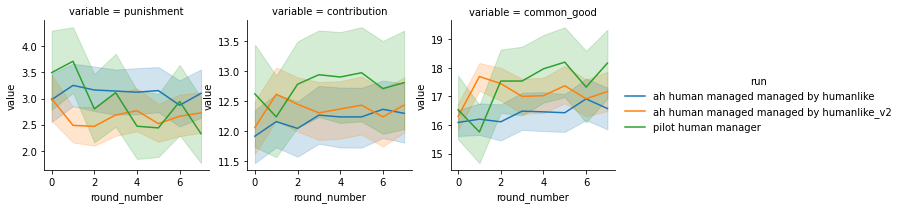

In [83]:
g = sns.relplot(
    data=dfm,
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line",
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot.jpg'))


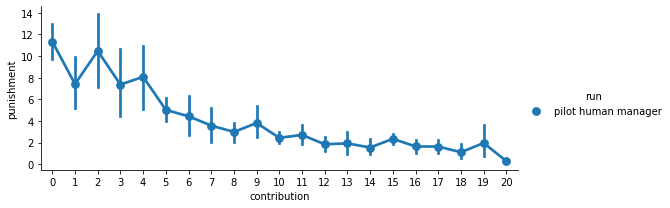

In [84]:
df['contribution'] = df['contribution'].astype(int)


w = df['run'].isin([
    'ah all managed by humanlike',
    'ah all managed by optimal',
    'pilot human manager',
    'pilot rule based manager'
])


g = sns.catplot(
    data=df[w],
    x="contribution", 
    y="punishment",
    hue='run',
    kind="point",
    height=3, aspect=2.5,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_policy.jpg'))

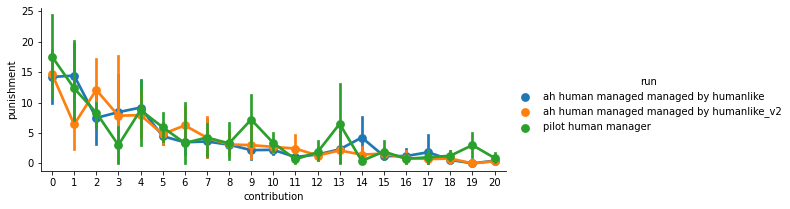

In [85]:
df['contribution'] = df['contribution'].astype(int)

w = (df['run'].isin([
    'ah human managed managed by humanlike',
    'ah human managed managed by humanlike_v2',    
    'pilot human manager',
]) & (df['round_number'] == 0))

g = sns.catplot(
    data=df[w],
    x="contribution", 
    y="punishment",
    hue='run',
    kind="point",
    height=3, aspect=2.5,
)

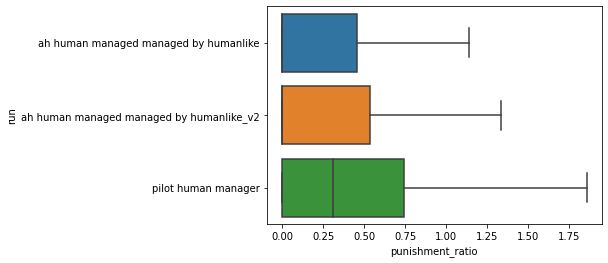

In [86]:
df['contribution'] = df['contribution'].astype(int)

w = (df['run'].isin([
    'ah human managed managed by humanlike',
    'ah human managed managed by humanlike_v2',
    'pilot human manager',
]) & (df['round_number'] == 0))

df['punishment_ratio'] = df['punishment'] / (20 - df['contribution'])

g = sns.boxplot(
    data=df[w],
    x="punishment_ratio", 
    y='run',
    showfliers=False,
)

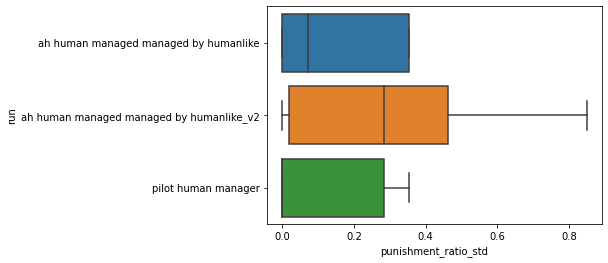

In [87]:
df['contribution'] = df['contribution'].astype(int)

w = (df['run'].isin([
    'ah human managed managed by humanlike',
    'ah human managed managed by humanlike_v2',
    'pilot human manager',
]) & (df['round_number'] == 0) & (df['contribution'] == 10))


dfs = df[w].copy()
dfs['punishment_ratio'] = dfs['punishment'] / (20 - dfs['contribution'])
dfs['punishment_ratio_std'] = dfs.groupby(['episode'])['punishment_ratio'].transform('std')

g = sns.boxplot(
    data=dfs,
    x="punishment_ratio_std", 
    y='run',
    showfliers=False,
)


<AxesSubplot:ylabel='Density'>

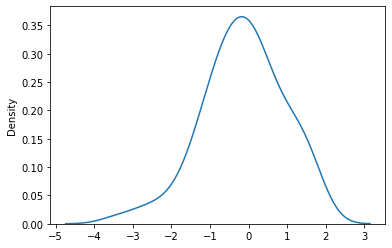

In [88]:
weights = mm.managers['humanlike_v2'].model.x_encoder.encoder[4].map.weight[:,0].detach().numpy()

sns.kdeplot(weights)

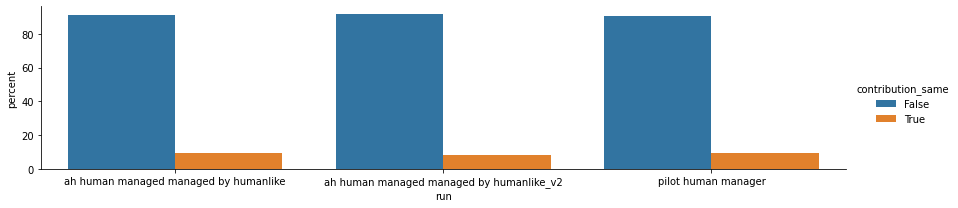

In [107]:
df['contribution'] = df['contribution'].astype(int)

w = (df['run'].isin([
    'ah human managed managed by humanlike',
    'ah human managed managed by humanlike_v2',
    'pilot human manager',
]) & (df['round_number'] == 0) & (df['contribution'] != 20))

dfs = df[w].copy()


merge_on = ['run','episode', 'round_number']
keep = ['punishment', 'contribution', 'participant_code']

dfm = pd.merge(left=dfs[merge_on+keep], right=dfs[merge_on+keep], on=merge_on)
dfm = dfm[dfm['participant_code_x'] != dfm['participant_code_y']]
dfm['contribution_same'] = dfm['contribution_x'] == dfm['contribution_y']
dfm['punishment_same'] = dfm['punishment_x'] == dfm['punishment_y']
dfm['punishment_diff'] = np.abs(dfm['punishment_x'] - dfm['punishment_y'])


x,y = 'run', 'contribution_same', 

(dfm
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x, y='percent',hue=y,kind='bar', height=3, aspect=4))

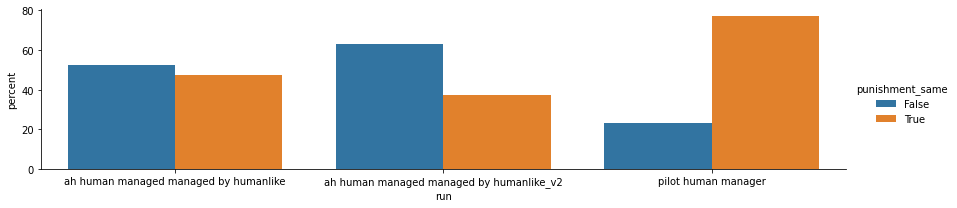

In [99]:
x,y = 'run', 'punishment_same', 

w = dfm['contribution_same']

(dfm[w]
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x, y='percent',hue=y,kind='bar', height=3, aspect=4))

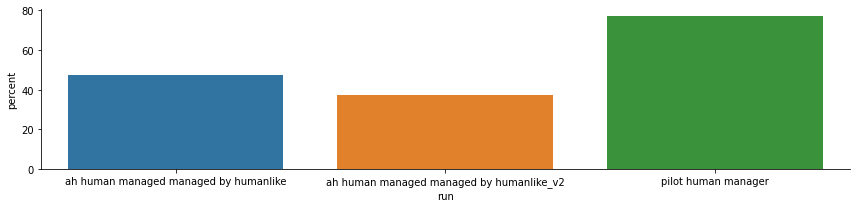

In [101]:
x,y = 'run', 'punishment_same', 

w = dfm['contribution_same']

((dfm[w]
.groupby(x)[y]
.mean()
.mul(100)
.rename('percent'))
.reset_index()
.pipe((sns.catplot,'data'), x=x, y='percent',kind='bar', height=3, aspect=4))

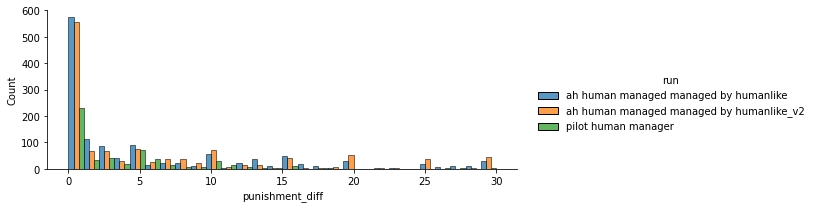

In [114]:

sns.displot(data=dfm, x='punishment_diff', hue='run', multiple='dodge', aspect=2.5, height=3)